# Environment

In [1]:
!pip install implicit
!pip install -U scikit-learn
!pip install numpy
!pip install matplotlib

# MF utils

In [2]:
from scipy.sparse import csr_matrix
from implicit.bpr import BayesianPersonalizedRanking
from implicit.evaluation import train_test_split, precision_at_k

def data_loader(user_item_table):
    np.random.seed(1234)
    user_item_csr = csr_matrix(user_item_table)
    user_item_train, user_item_test = train_test_split(user_item_csr, train_percentage=0.8)
    return user_item_train, user_item_test
def recommend_all(bpr, user_item_table, user_num, top_k):
    rank_list = list() 
    score_list = list()
    for user_id in range(user_num):
        reco = bpr.recommend(user_id, user_item_table, N=top_k, filter_already_liked_items=True)
        single_rank_list = [element[0] for element in reco]
        single_score_list = [element[1] for element in reco]
        rank_list.append(single_rank_list)
        score_list.append(single_score_list)
    return rank_list, score_list
def train(user_item_table, bpr=None):
    user_item_train, user_item_test = data_loader(user_item_table)
    np.random.seed(1234)
    if bpr:
        bpr.fit(user_item_train.T.tocsr())
    else:
        bpr = BayesianPersonalizedRanking(iterations=100)
        bpr.fit(user_item_train.T.tocsr()) 
    return bpr
def mf_neighnorhood(u_id, mf):
    return mf.similar_users(u_id)[1][0]

# Item Attributes

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from user_model import UserModel, Popularity
from calibration import *

class ItemAttributes:
    def __init__(self):
        
        self.user_num = 100 
        self.item_num = 1000
        startup_iter = 100 - 1 # start up until all itmes include
        
        self.pseudo_usermodel = UserModel(self.user_num, startup_iter)
        self.ideal_idx = self.pseudo_usermodel.add_model()
        
        ###### start-up ######
        while self.pseudo_usermodel.startup:
            self.pseudo_usermodel.recommend([None]*self.user_num, self.ideal_idx)
            self.pseudo_usermodel.new_iter()
                
        self.ideal_item_list = self.ideal_ItemList()
        
    def ideal_ItemList(self, user_model=None):
        user_ideal_list = []
        if not user_model:
            for item_vec in self.pseudo_usermodel.selected[self.ideal_idx]:
                user_ideal_list.append(np.nonzero(item_vec)[0].tolist()) # np.nonzero returns a tuple, so use np.nonzero()[0] to get the answer
        else:
            for item_vec in user_model.selected[0]:
                user_ideal_list.append(np.nonzero(item_vec)[0].tolist()) # np.nonzero returns a tuple, so use np.nonzero()[0] to get the answer
        return user_ideal_list
    

    def thresholding(self, user_model):
        # use mean as threshold
        attributes_threshold = np.mean(user_model.item_vec, axis=0) # shape : (item_vec_dim=20,)
        
        # map from "item index" to "Item Class"
        item_mapping = {}
        for item_id in range(self.item_num):
            item_vector = user_model.item_vec[item_id]
            attributes = (np.nonzero(item_vector >= attributes_threshold)[0]).tolist() # np.nonzero returns a tuple, so use np.nonzero()[0] to get the answer
            attributes_ratio = 1. / len(attributes)
            item_attributes = {single_attribute: attributes_ratio for single_attribute in attributes}
            item_mapping[item_id] = Item(item_id, item_attributes, score=None)
        
        return item_mapping
    
    def ItemDistribution(self, item_list, item_mapping):
        # elements in item_list are all item_id, and it's size is (user_num, *),  
        # e.g ranking list : (user_num, topK)
        # e.g ideal list : (user_num, num_InteractedItems_in_ideal_case)
        
        distribution_list = []
        # item mapping & compute distribution
        for user_item_list in item_list:
            preprocess_item_list = [item_mapping[item_id] for item_id in user_item_list]        
            distribution = compute_genre_distr(preprocess_item_list)
            distribution_list.append(distribution)

        return distribution_list
        

def calibration_all(rank_list, score_list, itemId2Item, ideal_distribution_list):
    calibrated_rank_list = []
    for user_id in range(len(rank_list)):

        # transform
        user_ranking_list = [itemId2Item[item_id] for item_id in rank_list[user_id]]
        user_score_list = score_list[user_id]

        # preprocess and get ideal distribution    
        for i in range(len(user_ranking_list)):
            user_ranking_list[i].score = user_score_list[i]
        user_ideal_distribution = ideal_distribution_list[user_id]

        # calibration
        postprocess_user_rank_list, _ = calib_recommend(user_ranking_list, user_ideal_distribution, topn=len(rank_list[user_id]), lmbda=0.99)
        calibrated_rank_list.append(postprocess_user_rank_list)
    return calibrated_rank_list

# 1.Offline Item List

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from user_model import UserModel, Popularity
from IPython.display import clear_output

jaccard_list = list()

for _ in range(10):

    _jaccard_list = list()

    user_num = 100
    iter_num = 100

    user_model = UserModel(user_num, 10, iter=iter_num)

    neighborhood = user_model.neighborhood()

    popularity_model = Popularity(user_num, 10 * iter_num)
    
    ideal_idx = user_model.add_model()
    popularity_idx = user_model.add_model()
    mf_idx = user_model.add_model()
    mf_calibration_idx = user_model.add_model()
    bpr = None # mf model
    bpr_calibration = None
    
    ### Calibration Config############
    pseudo_attributes = ItemAttributes()
    itemId2Item = pseudo_attributes.thresholding(user_model)
    ideal_distribution_list = pseudo_attributes.ItemDistribution(pseudo_attributes.ideal_item_list, itemId2Item)
    ##################################
    
    for iter in range(iter_num):
        clear_output(wait=True)
        # Ideal
        if iter < 10:
            user_model.recommend([[] for _ in range(user_num)], ideal_idx)
        else:
            user_model.recommend(user_model.get_ideal(ideal_idx), ideal_idx)
        
        ideal_jaccard = np.array([user_model.jaccard(ideal_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        # end Ideal

        # Popularity
        if iter < 10:
            feedback = user_model.recommend([[] for _ in range(user_num)], popularity_idx)
            popularity_model.feedback(feedback)
        else:
            pred = popularity_model.predict(user_model.selected[popularity_idx])
            feedback = user_model.recommend(pred, popularity_idx)
            popularity_model.feedback(feedback)

        popularity_jaccard = np.array([user_model.jaccard(popularity_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        # end Popularity
        
        # MF & MF calibration
        if iter < 10:
            feedback = user_model.recommend([[] for _ in range(user_num)], mf_idx)
            feedback = user_model.recommend([[] for _ in range(user_num)], mf_calibration_idx)
        else:
            if not bpr: 
                bpr = train(user_model.selected[mf_idx].copy(),None)
            if not bpr_calibration:
                bpr_calibration = train(user_model.selected[mf_calibration_idx].copy(), None)
             
            ########## MF ##############
            ## Inference
            old_user_item_table = user_model.selected[mf_idx].copy()
            top_k = 20 # assume recommend 20 items to each user
            rank_list, _ = recommend_all(bpr, csr_matrix(old_user_item_table), user_num=100, top_k=top_k) # size of rank_list : (user_num, top_k)

            ## User Interaction
            user_model.recommend(rank_list, model_idx=mf_idx)
            new_user_item_table = user_model.selected[mf_idx].copy()

            ## Retrain Model
            bpr = train(new_user_item_table, bpr)
            ###########################
            
            ######## MF Calibration #####
            ## Inference
            old_user_item_table = user_model.selected[mf_calibration_idx].copy()
            top_k = 20 # assume recommend 20 items to each user
            rank_list, score_list = recommend_all(bpr_calibration, csr_matrix(old_user_item_table), user_num=100, top_k=top_k) # size of rank_list : (user_num, top_k)
            post_rank_list = calibration_all(rank_list, score_list, itemId2Item, ideal_distribution_list)
            
            ## User Interaction
            user_model.recommend(post_rank_list, model_idx=mf_calibration_idx)
            new_user_item_table = user_model.selected[mf_calibration_idx].copy()

            ## Retrain Model
            bpr_calibration = train(new_user_item_table, bpr_calibration)
            ###########################
        if bpr:
            mf_jaccard = np.array([user_model.jaccard(mf_idx, u, mf_neighnorhood(u,bpr)) for u in range(user_num)]).mean()
            ideal_jaccard2 = np.array([user_model.jaccard(ideal_idx, u, mf_neighnorhood(u,bpr)) for u in range(user_num)]).mean()
        else:
            mf_jaccard = np.array([user_model.jaccard(mf_idx, u, neighborhood[u]) for u in range(user_num)]).mean() 
            ideal_jaccard2 = np.array([user_model.jaccard(ideal_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        # end MF
        if bpr_calibration:
            mf_calibration_jaccard = np.array([user_model.jaccard(mf_calibration_idx, u, mf_neighnorhood(u,bpr_calibration)) for u in range(user_num)]).mean()
            ideal_jaccard3 = np.array([user_model.jaccard(ideal_idx, u, mf_neighnorhood(u,bpr_calibration)) for u in range(user_num)]).mean()
        else:
            mf_calibration_jaccard = np.array([user_model.jaccard(mf_calibration_idx, u, neighborhood[u]) for u in range(user_num)]).mean() 
            ideal_jaccard3 = np.array([user_model.jaccard(ideal_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        # end MF calibration
        
        
        _jaccard_list.append([popularity_jaccard - ideal_jaccard, mf_jaccard - ideal_jaccard2, mf_calibration_jaccard - ideal_jaccard3])
        user_model.new_iter()
        
    jaccard_list.append(_jaccard_list)
    #clear_output()

In [ ]:
#jaccard_list = np.array(jaccard_list)
plt.clf()
plt.scatter(list(range(100)), np.array(jaccard_list).mean(axis=0)[:,0])
plt.scatter(list(range(100)), np.array(jaccard_list).mean(axis=0)[:,1])
plt.scatter(list(range(100)), np.array(jaccard_list).mean(axis=0)[:,2])

# result(lambda=0.5)

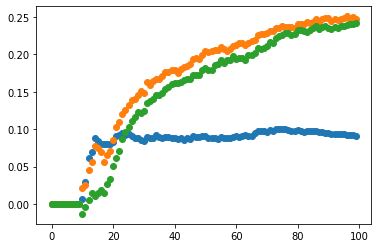

In [6]:
from IPython.display import Image
Image(filename='simulation_result/offline_05.png')

# result(lambda=0.99)

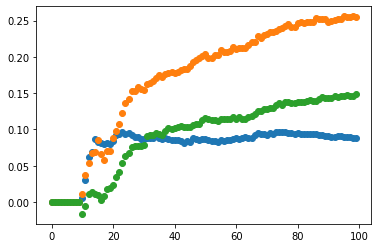

In [6]:
from IPython.display import Image
Image(filename='simulation_result/offline_099.png')

# 2.Online item list

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from user_model import UserModel, Popularity
from IPython.display import clear_output

jaccard_list = list()

for _ in range(10):

    _jaccard_list = list()

    user_num = 100
    iter_num = 100

    user_model = UserModel(user_num, 10, iter=iter_num)

    neighborhood = user_model.neighborhood()

    popularity_model = Popularity(user_num, 10 * iter_num)
    
    ideal_idx = user_model.add_model()
    popularity_idx = user_model.add_model()
    mf_idx = user_model.add_model()
    mf_calibration_idx = user_model.add_model()
    bpr = None # mf model
    bpr_calibration = None
    
    ### Calibration Config############
    pseudo_attributes = ItemAttributes()
    #itemId2Item = pseudo_attributes.thresholding(user_model)
    #ideal_distribution_list = pseudo_attributes.ItemDistribution(pseudo_attributes.ideal_item_list, itemId2Item)
    ##################################
    
    for iter in range(iter_num):
        clear_output(wait=True)
        # Ideal
        if iter < 10:
            user_model.recommend([[] for _ in range(user_num)], ideal_idx)
        else:
            user_model.recommend(user_model.get_ideal(ideal_idx), ideal_idx)
        
        ideal_jaccard = np.array([user_model.jaccard(ideal_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        # end Ideal

        # Popularity
        if iter < 10:
            feedback = user_model.recommend([[] for _ in range(user_num)], popularity_idx)
            popularity_model.feedback(feedback)
        else:
            pred = popularity_model.predict(user_model.selected[popularity_idx])
            feedback = user_model.recommend(pred, popularity_idx)
            popularity_model.feedback(feedback)

        popularity_jaccard = np.array([user_model.jaccard(popularity_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        # end Popularity
        
        # get attributes
        itemId2Item = pseudo_attributes.thresholding(user_model)
        ideal_item_list = pseudo_attributes.ideal_ItemList(user_model)
        ideal_distribution_list = pseudo_attributes.ItemDistribution(ideal_item_list, itemId2Item)
        # MF & MF calibration
        if iter < 10:
            feedback = user_model.recommend([[] for _ in range(user_num)], mf_idx)
            feedback = user_model.recommend([[] for _ in range(user_num)], mf_calibration_idx)
        else:
            if not bpr: 
                bpr = train(user_model.selected[mf_idx].copy(),None)
            if not bpr_calibration:
                bpr_calibration = train(user_model.selected[mf_calibration_idx].copy(), None)
             
            ########## MF ##############
            ## Inference
            old_user_item_table = user_model.selected[mf_idx].copy()
            top_k = 20 # assume recommend 20 items to each user
            rank_list, _ = recommend_all(bpr, csr_matrix(old_user_item_table), user_num=100, top_k=top_k) # size of rank_list : (user_num, top_k)

            ## User Interaction
            user_model.recommend(rank_list, model_idx=mf_idx)
            new_user_item_table = user_model.selected[mf_idx].copy()

            ## Retrain Model
            bpr = train(new_user_item_table, bpr)
            ###########################
            
            ######## MF Calibration #####
            ## Inference
            old_user_item_table = user_model.selected[mf_calibration_idx].copy()
            top_k = 20 # assume recommend 20 items to each user
            rank_list, score_list = recommend_all(bpr_calibration, csr_matrix(old_user_item_table), user_num=100, top_k=top_k) # size of rank_list : (user_num, top_k)
            post_rank_list = calibration_all(rank_list, score_list, itemId2Item, ideal_distribution_list)
            
            ## User Interaction
            user_model.recommend(post_rank_list, model_idx=mf_calibration_idx)
            new_user_item_table = user_model.selected[mf_calibration_idx].copy()

            ## Retrain Model
            bpr_calibration = train(new_user_item_table, bpr_calibration)
            ###########################
        if bpr:
            mf_jaccard = np.array([user_model.jaccard(mf_idx, u, mf_neighnorhood(u,bpr)) for u in range(user_num)]).mean()
            ideal_jaccard2 = np.array([user_model.jaccard(ideal_idx, u, mf_neighnorhood(u,bpr)) for u in range(user_num)]).mean()
        else:
            mf_jaccard = np.array([user_model.jaccard(mf_idx, u, neighborhood[u]) for u in range(user_num)]).mean() 
            ideal_jaccard2 = np.array([user_model.jaccard(ideal_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        # end MF
        if bpr_calibration:
            mf_calibration_jaccard = np.array([user_model.jaccard(mf_calibration_idx, u, mf_neighnorhood(u,bpr_calibration)) for u in range(user_num)]).mean()
            ideal_jaccard3 = np.array([user_model.jaccard(ideal_idx, u, mf_neighnorhood(u,bpr_calibration)) for u in range(user_num)]).mean()
        else:
            mf_calibration_jaccard = np.array([user_model.jaccard(mf_calibration_idx, u, neighborhood[u]) for u in range(user_num)]).mean() 
            ideal_jaccard3 = np.array([user_model.jaccard(ideal_idx, u, neighborhood[u]) for u in range(user_num)]).mean()
        # end MF calibration
        
        
        _jaccard_list.append([popularity_jaccard - ideal_jaccard, mf_jaccard - ideal_jaccard2, mf_calibration_jaccard - ideal_jaccard3])
        user_model.new_iter()
        
    jaccard_list.append(_jaccard_list)
    #clear_output()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

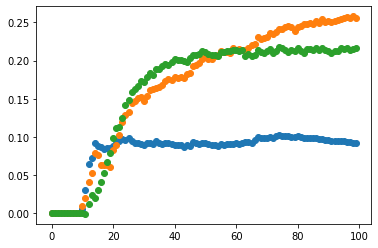

In [6]:
plt.clf()
plt.scatter(list(range(100)), np.array(jaccard_list).mean(axis=0)[:,0])
plt.scatter(list(range(100)), np.array(jaccard_list).mean(axis=0)[:,1])
plt.scatter(list(range(100)), np.array(jaccard_list).mean(axis=0)[:,2])

# result(lambda=0.99)

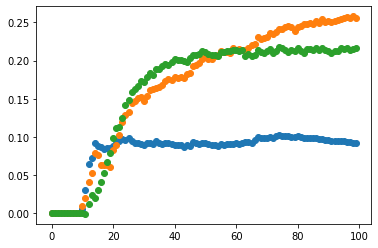

In [8]:
from IPython.display import Image
Image(filename='simulation_result/online_099.png') 